In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import pandas as pd
import numpy as np
from tqdm import tqdm

import networkx as nx
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN

from sklearn.model_selection import train_test_split


from tensorflow.keras.callbacks import Callback
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy

import wandb

2022-03-30 21:35:53.040993: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-30 21:35:53.041056: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mossad-xps
2022-03-30 21:35:53.041066: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mossad-xps
2022-03-30 21:35:53.041238: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.86.0
2022-03-30 21:35:53.041276: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.86.0
2022-03-30 21:35:53.041283: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.86.0
2022-03-30 21:35:53.041661: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

# Read Graphs --> NetworkX --> Stellargraph

In [7]:
def load_graphs_to_stellargraph(graph_uris, graphs_dir):
    uri_to_sg_graph = {}
    for uri in tqdm(graph_uris):
        file_path = os.path.join(graphs_dir, uri.lstrip('http://kglids.org/resource/kaggle/') + '.tsv')
        df_spo = pd.read_csv(file_path, delimiter='\t').astype(str)
        node_embeddings = pd.read_pickle(file_path.replace('.tsv', '.pickle'))
        g = nx.DiGraph()
        df_spo.apply(lambda x: g.add_edge(x['s'], x['o'], type=x['p']), axis=1)
        
        for node in g.nodes():
            g.nodes[node]['features'] = node_embeddings[node]['transE']#['complEx']  # TODO: complEx or transE?
    
        g = sg.StellarDiGraph.from_networkx(g, edge_type_attr='type', node_features='features')
        uri_to_sg_graph[uri] = g
    
    return uri_to_sg_graph

## Graph Classification model

In [10]:

def train_and_evaluate_classification_model(train_graphs, test_graphs, train_labels, test_labels, epochs=100, batch_size=50, sysname='KGLiDS'):
    gen = PaddedGraphGenerator(graphs=train_graphs+test_graphs)
    k = wandb.config.k  # the number of rows for the output tensor
    layer_sizes = [wandb.config.gcn_layer_size]* (wandb.config.gcn_layers - 1) + [1]   # last layer is of size 1. 
    activations = ["tanh"] * wandb.config.gcn_layers
    dgcnn_model = DeepGraphCNN(
        layer_sizes=layer_sizes,
        activations=activations,
        k=k,
        bias=False,
        generator=gen,
    )
    x_inp, x_out = dgcnn_model.in_out_tensors()

    x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
    x_out = MaxPool1D(pool_size=2)(x_out)

    x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

    x_out = Flatten()(x_out)

    x_out = Dense(units=wandb.config.fc_size, activation="relu")(x_out) #128
    x_out = Dropout(rate=wandb.config.dropout)(x_out)

    predictions = Dense(units=1, activation="sigmoid")(x_out)

    model = Model(inputs=x_inp, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=wandb.config.lr), loss=binary_crossentropy, metrics=["acc"])
    

    train_gen = gen.flow(
        graphs=train_graphs,
        targets=train_labels,
        batch_size=batch_size,
        symmetric_normalization=False,
    )

    test_gen = gen.flow(
        graphs=test_graphs,
        targets=test_labels,
        batch_size=1,
        symmetric_normalization=False,
    )
    
    # fit
    history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True)#, callbacks=[Metrics(model, test_graphs, test_labels)])
    for i in range(len(history.history['loss'])):
        wandb.log({"Epoch": i + 1, f"{sysname} Train Loss": history.history['loss'][i],
                   f"{sysname} Train Acc": history.history['acc'][i],
                   f"{sysname} Valid Loss": history.history['val_loss'][i],
                   f"{sysname} Valid Acc": history.history['val_acc'][i]})
    best_epoch = np.argmax(history.history['val_acc'])
    wandb.log({f"{sysname} Best Train Acc": history.history['acc'][best_epoch],
               f"{sysname} Best Valid Acc": history.history['val_acc'][best_epoch]})
    
    sg.utils.plot_history(history)
    
    # evaluate on test
    test_metrics = model.evaluate(test_gen)
    print("\nTest Set Metrics:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))



# Hyperparameters

In [2]:
wandb.init(project="task1-eda-vs-ml", config={'epochs': 30, 'dropout': 0.25, 'lr': 0.0001, 'gcn_layers': 5, 'gcn_layer_size': 32, 'k': 35, 'fc_size': 32})

wandb: Currently logged in as: mossadhelali (use `wandb login --relogin` to force relogin)


# Task Name

In [8]:
task = 'task1'


# get graph names and classes
uris_labels = pd.read_csv(f'{task}_uris_labels.csv')
uris_labels = uris_labels[uris_labels['uri'].apply(lambda x: os.path.exists(f'{task}_kglids_graphs/'+x.lstrip('http://kglids.org/resource/kaggle/') + '.tsv'))]
uris_labels = uris_labels[uris_labels['uri'].apply(lambda x: os.path.exists(f'{task}_kglids_graphs/'+x.lstrip('http://kglids.org/resource/kaggle/') + '.pickle'))]
uris_labels = uris_labels[uris_labels['uri'].apply(lambda x: os.path.exists(f'{task}_graph4code_graphs/'+x.lstrip('http://kglids.org/resource/kaggle/') + '.tsv'))]
uris_labels = uris_labels[uris_labels['uri'].apply(lambda x: os.path.exists(f'{task}_graph4code_graphs/'+x.lstrip('http://kglids.org/resource/kaggle/') + '.pickle'))]
uris_labels['label'] = uris_labels['label'].astype('category').cat.codes
pips = uris_labels['uri'].tolist()
labels = uris_labels['label'].tolist()
print(len(pips), 'Pipelines')
print(uris_labels.label.value_counts())

1974 Pipelines
1    995
0    979
Name: label, dtype: int64


In [7]:
kglids_stellargraph = load_graphs_to_stellargraph(pips, f'{task}_kglids_graphs')

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1974/1974 [00:59<00:00, 33.09it/s]


In [5]:
graph4code_stellargraph = load_graphs_to_stellargraph(pips, f'{task}_graph4code_graphs')

# Training a GCN Classifier

### Split to Train / Test

In [8]:
train_names, test_names, train_labels, test_labels = \
train_test_split(pips, labels, train_size=0.8, stratify=labels, random_state=3)

## KGLiDS:

Instructions for updating:
Use fn_output_signature instead
Epoch 1/30


/home/mossad/anaconda3/envs/kglids/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


32/32 [==============================] - 27s 821ms/step - loss: 0.6949 - acc: 0.4820 - val_loss: 0.6935 - val_acc: 0.4937
Epoch 2/30
32/32 [==============================] - 27s 830ms/step - loss: 0.6926 - acc: 0.5155 - val_loss: 0.6915 - val_acc: 0.5165
Epoch 3/30
32/32 [==============================] - 27s 840ms/step - loss: 0.6925 - acc: 0.5149 - val_loss: 0.6884 - val_acc: 0.5468
Epoch 4/30
32/32 [==============================] - 29s 894ms/step - loss: 0.6923 - acc: 0.5199 - val_loss: 0.6897 - val_acc: 0.5316
Epoch 5/30
32/32 [==============================] - 26s 799ms/step - loss: 0.6876 - acc: 0.5516 - val_loss: 0.6875 - val_acc: 0.5139
Epoch 6/30
32/32 [==============================] - 26s 812ms/step - loss: 0.6824 - acc: 0.5541 - val_loss: 0.6916 - val_acc: 0.5165
Epoch 7/30
32/32 [==============================] - 27s 831ms/step - loss: 0.6774 - acc: 0.5896 - val_loss: 0.6889 - val_acc: 0.5519
Epoch 8/30
32/32 [==============================] - 27s 839ms/step - loss: 0.673

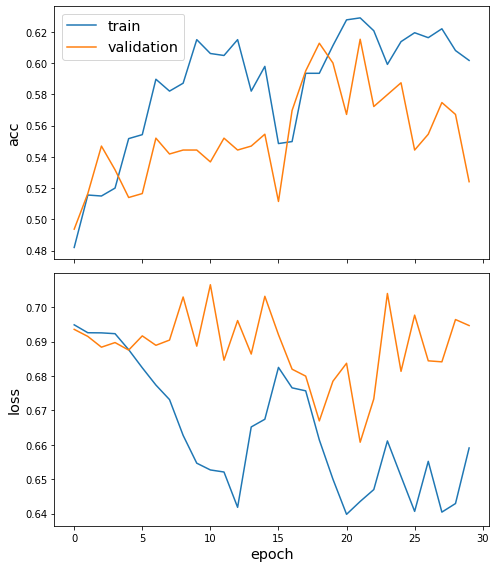

In [11]:
train_and_evaluate_classification_model([kglids_stellargraph[i] for i in train_names],
                                        [kglids_stellargraph[i] for i in test_names],
                                        train_labels, test_labels, epochs=wandb.config.epochs, batch_size=50, 
                                        sysname='KGLiDS')

## GraphGen4Code:

Epoch 1/40


/home/mossad/anaconda3/envs/kglids/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_8/sort_pooling_8/map/while/gradients/model_8/sort_pooling_8/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_8/sort_pooling_8/map/while/gradients/model_8/sort_pooling_8/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_8/sort_pooling_8/map/while/gradients/model_8/sort_pooling_8/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


316/316 [==============================] - 169s 534ms/step - loss: 0.6911 - acc: 0.5282 - val_loss: 0.6848 - val_acc: 0.5722
Epoch 2/40
316/316 [==============================] - 153s 480ms/step - loss: 0.6921 - acc: 0.5548 - val_loss: 0.6967 - val_acc: 0.4987
Epoch 3/40
316/316 [==============================] - 144s 454ms/step - loss: 0.6883 - acc: 0.5396 - val_loss: 0.6925 - val_acc: 0.5266
Epoch 4/40
316/316 [==============================] - 146s 460ms/step - loss: 0.6797 - acc: 0.5624 - val_loss: 0.6735 - val_acc: 0.5772
Epoch 5/40
316/316 [==============================] - 144s 454ms/step - loss: 0.6742 - acc: 0.5909 - val_loss: 0.6762 - val_acc: 0.5797
Epoch 6/40
316/316 [==============================] - 141s 443ms/step - loss: 0.6814 - acc: 0.5554 - val_loss: 0.6780 - val_acc: 0.5494
Epoch 7/40
316/316 [==============================] - 145s 459ms/step - loss: 0.6866 - acc: 0.5484 - val_loss: 0.6917 - val_acc: 0.5038
Epoch 8/40
316/316 [==============================] - 144s 

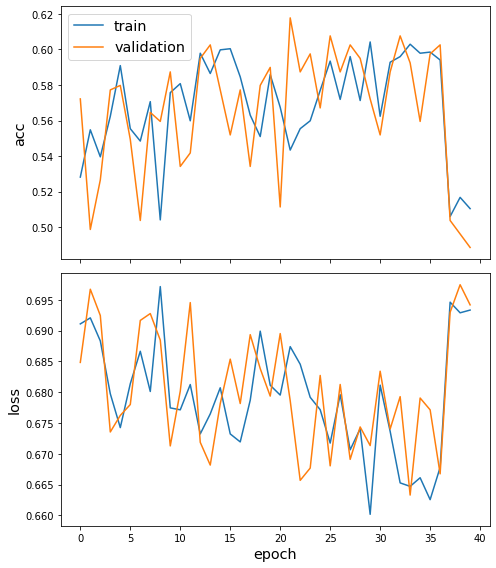

In [20]:
train_and_evaluate_classification_model([graph4code_stellargraph[i] for i in train_names],
                                        [graph4code_stellargraph[i] for i in test_names], 
                                        train_labels, test_labels, epochs=wandb.config.epochs, 
                                        batch_size=5, sysname='GraphGen4Code')